In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import torchvision.datasets as dsets

In [21]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=128, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
args = parser.parse_args([])
print(args)

cuda = True if torch.cuda.is_available() else False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Namespace(n_epochs=200, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=128, channels=3, sample_interval=400)
Using cpu device


In [2]:
import cv2

all_images = os.listdir('celeba/img_align_celeba/')
img = cv2.imread('celeba/img_align_celeba/' + all_images[0])
img.shape

(218, 178, 3)

In [5]:
resize = transforms.Resize(64)
to_tensor = transforms.ToTensor()

resize(to_tensor(img)).shape

torch.Size([3, 78, 64])

In [3]:
crop_size = (128,128)

train_dataset = dsets.CelebA(
    root='./',
    split = 'train',
    transform=transforms.Compose(
        [
            transforms.Resize(args.img_size),
            transforms.ToTensor(), 
            transforms.Normalize([0.5], [0.5]),
            transforms.RandomCrop(crop_size)
        ]
    ),
    download=False
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=args.batch_size, shuffle=True)

NameError: name 'args' is not defined

In [23]:
x,y = train_dataset[0]
img_shape = tuple(x.shape)
img_shape

(3, 128, 128)

In [10]:
def denormalize(t):
    return t * 0.5 + 0.5
denormalize(x).mean(), denormalize(x).min(), denormalize(x).max()

(tensor(0.5702), tensor(0.), tensor(1.))

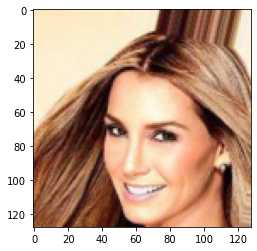

In [24]:
import matplotlib.pyplot as plt

plt.imshow(  denormalize(x).permute(1, 2, 0)  )

In [2]:
from generator import Generator2

gen = Generator2()

noise = torch.randn((10,100)).view(10,100,1,1)
noise.shape

gen_imgs = gen(noise)
gen_imgs.shape

torch.Size([10, 100, 1, 1])

In [3]:
gen_imgs = gen(noise)
gen_imgs.shape

torch.Size([10, 3, 79, 79])

In [10]:
from torchvision.utils import make_grid, save_image

grid = make_grid(gen_imgs, normalize=True)

save_image(grid, 'test.png')

In [200]:
import torch
import torch.nn as nn
import numpy as np


class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        # self.main = nn.Sequential(
        #     # Block 1: input is (3) x 64 x 64
        #     nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # Block 2: input is (64) x 32 x 32
        #     nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(64 * 2),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # Block 3: input is (64*2) x 16 x 16
        #     nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(64 * 4),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # Block 4: input is (64*4) x 8 x 8
        #     nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(64 * 8),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # Block 5: input is (64*8) x 4 x 4
        #     nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
        #     nn.Sigmoid(),
        #     nn.Flatten()
        # )


        self.disc = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),    
            nn.Conv2d(128, 128, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(3),
            nn.Flatten()
        )

        t = torch.zeros(img_shape).unsqueeze(0)

        with torch.no_grad():
            t = self.disc(t)
            print('t', t.shape)
            flat_dim = t.shape[1]

        print('flat_dim=', flat_dim)
        self.fc = torch.nn.Sequential(
            nn.Linear(flat_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.disc(x)
        print('a', x.shape)

        x = self.fc(x)
        print('b', x.shape)
        
        return x


z = torch.Tensor(np.random.normal(0, 1, (15,3, 78, 64)), device=device)
D = Discriminator(img_shape)
D(z)

t torch.Size([1, 256])
flat_dim= 256
a torch.Size([15, 256])
b torch.Size([15, 1])


tensor([[0.4594],
        [0.4598],
        [0.4599],
        [0.4600],
        [0.4598],
        [0.4601],
        [0.4601],
        [0.4599],
        [0.4599],
        [0.4597],
        [0.4603],
        [0.4600],
        [0.4598],
        [0.4600],
        [0.4599]], grad_fn=<SigmoidBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


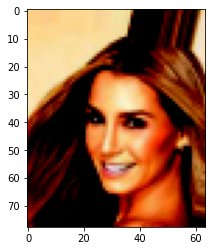

In [8]:
import matplotlib.pyplot as plt

plt.imshow(  x.permute(1, 2, 0)  )

In [186]:
import numpy as np
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, latent_dim_channels, img_shape):
        super(Generator, self).__init__()
        out_channels = 3
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(latent_dim_channels, 1024, 2, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d( 512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d( 256, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d( 128, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

        self.upscale = torch.nn.Upsample((img_shape[1], img_shape[2]))

    def forward(self, z):
        z = self.gen(z)
        return self.upscale(z)

lc = 10
b = 1

gen = Generator(lc, img_shape)
z = torch.Tensor(np.random.normal(0, 1, (b, lc, 5, 4)), device=device)

with torch.no_grad():
    out = gen(z)
out.shape

torch.Size([1, 3, 78, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


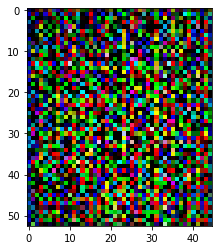

In [183]:
plt.imshow(  out.squeeze(0).permute(1, 2, 0)  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


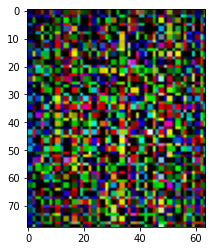

In [184]:
upscale = torch.nn.Upsample((78,64))

plt.imshow(  upscale(out).squeeze(0).permute(1, 2, 0)  )

In [108]:
z = 10
z * 78/64, z

(12.1875, 10)

In [44]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [45]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# if cuda:
#     generator.cuda()
#     discriminator.cuda()
#     adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.lr, betas=(args.b1, args.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.lr, betas=(args.b1, args.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [47]:
os.makedirs("debug", exist_ok=True)

In [48]:
# ----------
#  Training
# ----------

for epoch in range(args.n_epochs):
    for i, (imgs, _) in enumerate(train_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], args.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, args.n_epochs, i, len(train_loader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(train_loader) + i
        if batches_done % args.sample_interval == 0:
            save_image(gen_imgs.data[:25], "debug/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/200] [Batch 0/2544] [D loss: 0.162388] [G loss: 1.312285]
[Epoch 0/200] [Batch 1/2544] [D loss: 0.156040] [G loss: 1.339926]
[Epoch 0/200] [Batch 2/2544] [D loss: 0.154395] [G loss: 1.369625]
[Epoch 0/200] [Batch 3/2544] [D loss: 0.161026] [G loss: 1.374343]
[Epoch 0/200] [Batch 4/2544] [D loss: 0.183815] [G loss: 1.379583]
[Epoch 0/200] [Batch 5/2544] [D loss: 0.175746] [G loss: 1.420245]
[Epoch 0/200] [Batch 6/2544] [D loss: 0.197090] [G loss: 1.464151]
[Epoch 0/200] [Batch 7/2544] [D loss: 0.158563] [G loss: 1.631523]
[Epoch 0/200] [Batch 8/2544] [D loss: 0.156276] [G loss: 1.679219]
[Epoch 0/200] [Batch 9/2544] [D loss: 0.113764] [G loss: 1.780622]
[Epoch 0/200] [Batch 10/2544] [D loss: 0.125996] [G loss: 1.652803]
[Epoch 0/200] [Batch 11/2544] [D loss: 0.135644] [G loss: 1.534334]
[Epoch 0/200] [Batch 12/2544] [D loss: 0.164580] [G loss: 1.427266]
[Epoch 0/200] [Batch 13/2544] [D loss: 0.228747] [G loss: 1.196325]
[Epoch 0/200] [Batch 14/2544] [D loss: 0.261728] [G loss: 

KeyboardInterrupt: 